# Two tasks performed in this notebook:
- Run the VoteNet architecture on a demo input
- Train the VoteNet architecture on our desired set of object classes

**Note to TA**: Please click "*Add shortcut to drive*" on the [rvsu drive link](https://drive.google.com/drive/folders/1Aych07wnhjIN9VrUQz4fJYH1daF5JUx4?usp=sharing)

Access is enabled for IIT Bombay ldap accounts

In [1]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install -q plyfile
!pip install -q trimesh==2.35.39
!pip install -q networkx==2.2

     |████████████████████████████████| 286kB 12.2MB/s 
     |████████████████████████████████| 1.7MB 11.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


## Running demo.py on VoteNet

In [3]:
cd /content/drive/MyDrive/rvsu/votenet/pointnet2

/content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet/pointnet2


In [4]:
!python3 setup.py install &> /dev/null

### Input image
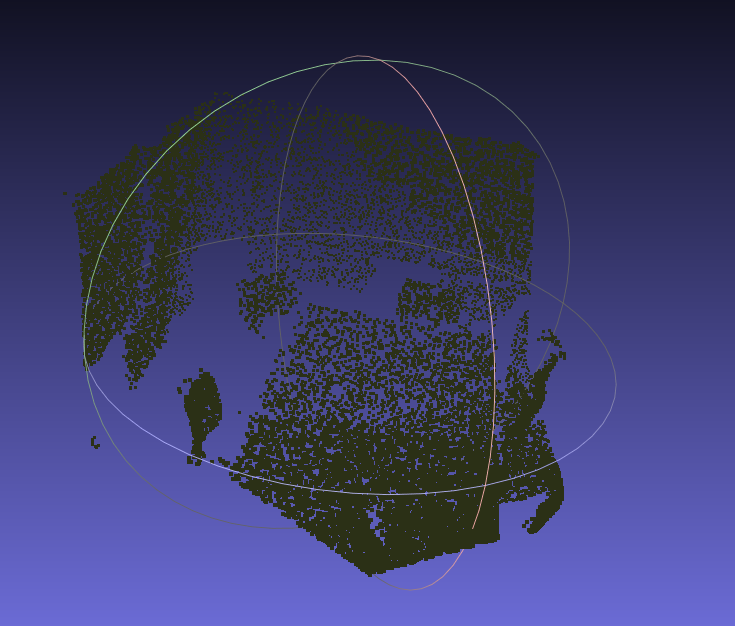

The above is a pointcloud image of an office scene containing chairs and a table

In [5]:
cd ..

/content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet


In [6]:
!python3 demo.py

Constructed model.
Loaded checkpoint /content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet/demo_files/pretrained_votenet_on_sunrgbd.tar (epoch: 180)
Loaded point cloud data: /content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet/demo_files/input_pc_sunrgbd.ply
Inference time: 0.197954
Finished detection. 8 object detected.
1
3
3
3
1
3
3
3
Dumped detection results to folder /content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet/demo_files/sunrgbd_results


Above, class 1 corresponds to table and class 3 corresponds to chair

# Training

## Prepare SUN RGB-D Data

(Took up most of the time)

Convert `.mat` files containing our desired class labels into pointcloud files. The votenet script finally trains on the pointcloud files and their labels

We followed all steps mentioned in the SunRGBD data preparation [guidelines](https://github.com/facebookresearch/votenet/blob/master/sunrgbd/README.md). The first part of the data extraction involving a Matlab script had to be performed on our local system. We uploaded the resultant 37 GB worth of `.mat` files and other label meta-data to GDrive [here](https://drive.google.com/drive/folders/1XXfKRajkMuY7_85Ap0ks3grHPlFF5DPU?usp=sharing). Then scipy module's `io` library congregates information from multiple directories to produce the labelled pointcloud dataset `sunrgbd_pc_bbox_votes_50k_v2_train` [here](https://drive.google.com/drive/folders/1DHudDje8Uu2vnEtw1esPaemDUWXobDWU?usp=sharing).

In [ ]:
cd /content/drive/MyDrive/rvsu/votenet/sunrgbd/

/content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet/sunrgbd


In [ ]:
!python sunrgbd_data.py --gen_v2_data

Streaming output truncated to the last 5000 lines.
-------------  5851
-------------  5852
-------------  5853
-------------  5854
-------------  5855
-------------  5856
-------------  5857
-------------  5858
survivor 577
-------------  5859
-------------  5860
-------------  5861
-------------  5862
-------------  5863
-------------  5864
-------------  5865
-------------  5866
-------------  5867
-------------  5868
-------------  5869
-------------  5870
-------------  5871
-------------  5872
-------------  5873
-------------  5874
-------------  5875
-------------  5876
-------------  5877
-------------  5878
-------------  5879
-------------  5880
-------------  5881
survivor 578
-------------  5882
-------------  5883
-------------  5884
-------------  5885
-------------  5886
-------------  5887
-------------  5888
-------------  5889
-------------  5890
-------------  5891
-------------  5892
-------------  5893
-------------  5894
-------------  5895
-------------  5896
---

## Get mean 3D bounding boxes sizes
These values are required in the `model_util_sunrgbd.py` script

(Takes a long time to run)

In [ ]:
import os
import sys
import numpy as np
import sys
import cv2
import argparse
from PIL import Image
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, '../utils/'))
import pc_util
import sunrgbd_utils

class sunrgbd_object(object):
    ''' Load and parse object data '''
    def __init__(self, root_dir, split='training', use_v1=False):
        self.root_dir = root_dir
        self.split = split
        assert(self.split=='training') 
        self.split_dir = os.path.join(root_dir)

        if split == 'training':
            self.num_samples = 10335
        elif split == 'testing':
            self.num_samples = 2860
        else:
            print('Unknown split: %s' % (split))
            exit(-1)

        self.image_dir = os.path.join(self.split_dir, 'image')
        self.calib_dir = os.path.join(self.split_dir, 'calib')
        self.depth_dir = os.path.join(self.split_dir, 'depth')
        if use_v1:
            self.label_dir = os.path.join(self.split_dir, 'label_v1')
        else:
            self.label_dir = os.path.join(self.split_dir, 'label')

    def __len__(self):
        return self.num_samples

    def get_image(self, idx):
        img_filename = os.path.join(self.image_dir, '%06d.jpg'%(idx))
        return sunrgbd_utils.load_image(img_filename)

    def get_depth(self, idx): 
        depth_filename = os.path.join(self.depth_dir, '%06d.mat'%(idx))
        return sunrgbd_utils.load_depth_points_mat(depth_filename)

    def get_calibration(self, idx):
        calib_filename = os.path.join(self.calib_dir, '%06d.txt'%(idx))
        return sunrgbd_utils.SUNRGBD_Calibration(calib_filename)

    def get_label_objects(self, idx):
        label_filename = os.path.join(self.label_dir, '%06d.txt'%(idx))
        return sunrgbd_utils.read_sunrgbd_label(label_filename)

In [ ]:
dataset = sunrgbd_object('./sunrgbd_trainval')
dimension_list = []
type_list = []
ry_list = []
# data_idx_list = [int(line.rstrip()) for line in open(idx_filename)]
for data_idx in range(1,10336):
    print('------------- ', data_idx)
    calib = dataset.get_calibration(data_idx) # 3 by 4 matrix
    objects = dataset.get_label_objects(data_idx)
    for obj_idx in range(len(objects)):
        obj = objects[obj_idx]
        heading_angle = -1 * np.arctan2(obj.orientation[1], obj.orientation[0])
        dimension_list.append(np.array([obj.l,obj.w,obj.h])) 
        type_list.append(obj.classname) 
        ry_list.append(heading_angle)

In [ ]:
box3d_pts = np.vstack(dimension_list)
for class_type in sorted(set(type_list)):
    cnt = 0
    box3d_list = []
    for i in range(len(dimension_list)):
        if type_list[i]==class_type:
            cnt += 1
            box3d_list.append(dimension_list[i])
    print(class_type)
    median_box3d = np.median(box3d_list,0)
    print(f"[{median_box3d[0]*2}, {median_box3d[1]*2}, {median_box3d[2]*2}]")

## Actual training begins here

(Took about 2 hours)

In [ ]:
cd /content/drive/MyDrive/rvsu/votenet/

/content/drive/.shortcut-targets-by-id/1uy_25Ktos6aggwUlwJHpayeq5FvWPMpT/votenet


In [ ]:
!python3 train.py -h

2021-04-29 18:36:50.779438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
usage: train.py [-h] [--model MODEL] [--dataset DATASET]
                [--checkpoint_path CHECKPOINT_PATH] [--log_dir LOG_DIR]
                [--dump_dir DUMP_DIR] [--num_point NUM_POINT]
                [--num_target NUM_TARGET] [--vote_factor VOTE_FACTOR]
                [--cluster_sampling CLUSTER_SAMPLING]
                [--ap_iou_thresh AP_IOU_THRESH] [--max_epoch MAX_EPOCH]
                [--batch_size BATCH_SIZE] [--learning_rate LEARNING_RATE]
                [--weight_decay WEIGHT_DECAY] [--bn_decay_step BN_DECAY_STEP]
                [--bn_decay_rate BN_DECAY_RATE]
                [--lr_decay_steps LR_DECAY_STEPS]
                [--lr_decay_rates LR_DECAY_RATES] [--no_height] [--use_color]
                [--use_sunrgbd_v2] [--overwrite] [--dump_results]

optional arguments:
  -h, --help            show this help message and e

In [ ]:
!python3 train.py --dataset sunrgbd --use_sunrgbd_v2 --log_dir log_sunrgbd

Streaming output truncated to the last 5000 lines.
mean heading_cls_loss: 1.206699
mean heading_reg_loss: 0.086949
mean loss: 5.865231
mean neg_ratio: 0.777344
mean obj_acc: 0.927301
mean objectness_loss: 0.055469
mean pos_ratio: 0.075586
mean sem_cls_loss: 0.294722
mean size_cls_loss: 0.295134
mean size_reg_loss: 0.047799
mean vote_loss: 0.211978
 ---- batch: 060 ----
mean box_loss: 0.389687
mean center_loss: 0.032296
mean heading_cls_loss: 1.470301
mean heading_reg_loss: 0.113731
mean loss: 6.600290
mean neg_ratio: 0.796338
mean obj_acc: 0.920934
mean objectness_loss: 0.057497
mean pos_ratio: 0.062793
mean sem_cls_loss: 0.300275
mean size_cls_loss: 0.300403
mean size_reg_loss: 0.066590
mean vote_loss: 0.211566
 ---- batch: 070 ----
mean box_loss: 0.346954
mean center_loss: 0.040098
mean heading_cls_loss: 1.172607
mean heading_reg_loss: 0.096531
mean loss: 6.248460
mean neg_ratio: 0.772119
mean obj_acc: 0.931662
mean objectness_loss: 0.058923
mean pos_ratio: 0.078564
mean sem_cls_loss